In [8]:
import numpy as np
from sklearn.datasets import load_digits

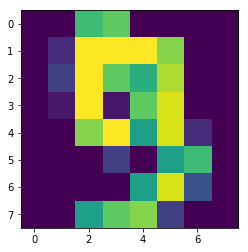

In [9]:
import matplotlib.pyplot as plt
digits = load_digits()
data = digits.data
image = data[9].reshape(8,8)
plt.imshow(image)
plt.show()

In [10]:
class Data:
    def __init__(self,x, y, batch_size):
        self.x = x
        self.y = y
        self.l = x.shape[1]
        self.batch_size = batch_size
        self.pos = 0
        
    def forward(self):
        #Mini-batch
        pos = self.pos
        bat = self.batch_size
        l = self.l
        if pos + bat >= l:
            ret = (self.x[:,pos:l], self.y[pos:l])
            self.pos = 0
            index = range(l)
            np.random.shuffle(list(index))
            self.x = self.x[:,index]
            self.y = self.y[index]
        else:
            ret = (self.x[:,pos:pos+bat], self.y[pos:pos+bat])
            self.pos += self.batch_size
        
        return ret, self.pos
    def backward(self, d):
        pass

In [328]:
class FullyConnect:
    def __init__(self, l_x, l_y, L2 = 0, keep_prob = 1, methods = 'Grad',
                 k1=0.9, k2=0.999, batch_normal = False, predict = False):
        np.random.seed(42)
        self.l_x = l_x
        self.weights = np.random.randn(l_y, l_x)*np.sqrt(2/l_x)
        self.bias = np.random.randn(l_y, 1)
        self.lr = 0
        self.L2 = L2
        self.keep_prob = keep_prob
        self.methods = methods
        #Monmentum
        self.vdw = 0
        self.vdb = 0
        #RmSprop
        self.sdw = 0
        self.sdb = 0
        #Adam
        
        #batch-Normalization
        self.batch_normal =  batch_normal
        self.gram = np.random.randn(l_y, 1)
        self.beta = np.random.randn(l_y, 1)
        self.mean = np.zeros((l_y, 1))
        self.std = np.zeros((l_y, 1))
        self.predict = predict
        
    def forward(self, x):
        #drop-out
        iskeep = np.random.rand(1, self.l_x)<self.keep_prob
        self.keep_weights = self.weights*iskeep/self.keep_prob
        
        self.x = x
        
        self.y = np.dot(self.keep_weights, self.x)+self.bias
        
        # batch-Normalization
        if self.batch_normal:
            self._batch_normalization()
        
        return self.y 
    
    def _batch_normalization(self):
        if self.predict:
            predict_y_norm = (self.y-self.mean)/(self.std+1e-8)
            self.y = self.gram*predict_y_norm + self.beta
        else:
            n = self.y.shape[1]
            self.tmean = np.mean(self.y, axis = 1, keepdims=True)
            self.tstd = np.std(self.y, axis = 1, keepdims=True)
            self.y_norm = (self.y-self.tmean)/(self.tstd+1e-8)
            self.y = self.gram*self.y_norm + self.beta

            self.mean = 0.9*self.mean + 0.1*self.tmean
            self.std = 0.9*self.std + 0.1*self.tstd
    
    def backward(self, d):
        if self.batch_normal:
            d = d*self.gram/self.tstd
            self.dgram = d*self.y_norm
            self.gram -= self.lr*np.sum(self.dgram, axis = 1, keepdims=True)/self.y.shape[1]
            self.beta -= self.lr*np.sum(d, axis = 1, keepdims=True)/self.y.shape[1]
            
        self.dw = np.dot(d, self.x.T)/self.x.shape[1]+self.L2*self.keep_weights/(2*self.x.shape[1])
        self.db = np.sum(d, axis = 1, keepdims=True)/self.x.shape[1]
        self.dx = np.dot(self.keep_weights.T, d)
        
        #优化
        self._optimize(self.methods)
        return self.dx
    def _optimize(self, methods='Grad', k1=0.9, k2=0.999):
        if methods == 'Grad':
            self.weights -= self.lr * self.dw
            self.bias -= self.lr * self.db
        elif methods == 'Monmentum':
            #未修正
            self.vdw = k1*self.vdw+(1-k1)*self.dw
            self.vdb = k1*self.vdb+(1-k1)*self.db
            self.weights -= self.lr * self.vdw
            self.bias -= self.lr * self.vdb
        elif methods == 'RMSprop':
            #未修正
            self.sdw = k2*self.sdw + (1-k2)*self.dw**2
            self.sdb = k2*self.sdb + (1-k2)*self.db**2
            self.weights -= self.lr*self.dw/(np.sqrt(self.sdw)+1e-8)
            self.bias -= self.lr*self.db/(np.sqrt(self.sdb)+1e-8)
        elif methods == 'Adam':
            self.vdw = k1*self.vdw+(1-k1)*self.dw
            self.vdb = k1*self.vdb+(1-k1)*self.db
            self.sdw = k2*self.sdw + (1-k2)*self.dw**2
            self.sdb = k2*self.sdb + (1-k2)*self.db**2
            
            self.weights -= self.lr*self.vdw/(np.sqrt(self.sdw)+1e-8)
            self.bias -= self.lr*self.vdb/(np.sqrt(self.sdb)+1e-8)

In [329]:
class Sigmoid:
    def __init__(self):
        pass
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    def forward(self, x):
        self.x = x
        self.y = self.sigmoid(x)
        return self.y
    def backward(self, d):
        sig = self.sigmoid(self.x)
        self.dx = d*sig*(1-sig)
        return self.dx

In [330]:
class Relu1:
    def __init__(self):
        pass
    def relu1(self, x):
        s = np.ones_like(x)/10
        s[x > 0] = 1
        return x*s
    def forward(self, x):
        self.x = x
        self.y = self.relu1(x)
        return self.y
    def backward(self, d):
        s = np.ones_like(self.x)/10
        s[self.x > 0] = 1
        return d*s

In [331]:
class Relu:
    def __init__(self):
        pass
    def relu(self, x):
        return x*(x>0)
    def forward(self, x):
        self.x = x
        self.y = self.relu(x)
        return self.y
    def backward(self, d):
        r = self.x > 0
        return d*r

In [332]:
class Tanh:
    def __init__(self):
        pass
    def tanh(self, x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    def forward(self, x):
        self.x = x
        self.y = self.tanh(x)
        return self.y
    def backward(self, d):
        t = 1-self.tanh(self.x)**2
        return d*t

In [333]:
class QuadraticLoss:
    def __init__(self, L2):
        self.L2 = L2
    def forward(self, x, label):
        self.x = x
        self.label = np.zeros_like(x)
        for i in range(len(label)):
            self.label[label[i], i] = 1
        self.loss = np.sum(np.square(self.x - self.label))/self.x.shape[1]/2
        return self.loss
    def backward(self):
        self.dx = (self.x - self.label)
        return self.dx

In [334]:
class Accuracy:
    def __init__(self):
        pass
    def forward(self, x, label):
        self.accuracy = 0
        for i in range(len(label)):
            xx = np.argmax(x[:, i])
            if xx == label[i]:
                self.accuracy += 1
        self.accuracy = 1.0*self.accuracy/x.shape[1]
        return self.accuracy

In [335]:
class ANN:
    def __init__(self, layer_sizes, epochs = 20,batch_size = 1, learning_rate = 0.01, L2 = 0, keep_probs=None,
                methods = 'Grad', k1=0.9, k2=0.999, batch_normal = False):
        self.ls = layer_sizes
        self.bs = batch_size
        self.lr = learning_rate
        self.epochs = epochs
        
        #正则化
        self.L2 = L2
        self.keeｐ_probs = keep_probs
        
        #优化算法
        self.methods = methods
        self.k1 = k1
        self.k2 = k2
        
        #batch-normal
        self.batch_normal = batch_normal
        
    def fit(self, X, y):
        data_layer = Data(X, y, self.bs)
        input_size = X.shape[0]
        out_size = len(set(y))
        inner_layers = []   
        
        losslayer = QuadraticLoss(0)
        
        if self.ls == []:
            inner_layers.append(FullyConnect(input_size, out_size, self.L2))
            inner_layers.append(Sigmoid())
        elif self.ls != None:
            inner_layers.append(FullyConnect(input_size, self.ls[0], self.L2, batch_normal=self.batch_normal))
            inner_layers.append(Relu1())
            
            for i in range(0, len(self.ls)-1):
                full_layer = FullyConnect(self.ls[i], self.ls[i+1], self.L2, batch_normal=self.batch_normal)
                if self.keep_probs != None:
                    full_layer.keep_prob = self.keep_probs[i]
                inner_layers.append(full_layer)
                inner_layers.append(Relu1())
            
            inner_layers.append(FullyConnect(self.ls[-1], out_size, self.L2))
            inner_layers.append(Sigmoid())
            
        for layer in inner_layers:
            layer.lr = self.lr # 为所有中间层设置学习速率
            
            layer.methods = self.methods
            layer.k1 = self.k1
            layer.k2 = self.k2
        
        print(len(inner_layers))
        #学习
        for i in range(self.epochs):
            losssum = 0
            iters = 0
            print('epochs:', i)   
            while True:
                data, pos = data_layer.forward()  # 从数据层取出数据
                x, label = data
                for layer in inner_layers:  # 前向计算
                    x = layer.forward(x)
                
                loss = losslayer.forward(x, label)  # 调用损失层forward函数计算损失函数值
                losssum += loss
                iters += 1
                d = losslayer.backward()  # 调用损失层backward函数层计算将要反向传播的梯度
                for layer in inner_layers[::-1]:  # 反向传播
                    d = layer.backward(d)
                if pos == 0:
                    print('loss:', losssum / iters)
                    break
        self.inner_layers = inner_layers
    
    def predict(self,X):
        for layer in self.inner_layers:
            layer.predict = True
            X = layer.forward(X)
        return Ｘ
    
    def accuracy(self, y2, y):
        accuracy = Accuracy()
        accu = accuracy.forward(y2, y)  # 调用准确率层forward()函数求出准确率
        print('accuracy:', accu)
        return accu

In [336]:
from sklearn.preprocessing import StandardScaler
digits = load_digits()
data = digits.data
target = digits.target
scaler = StandardScaler()
data = scaler.fit_transform(data)

train_x = data[:1500].T; train_y = target[:1500]
test_x = data[1500:].T; test_y = target[1500:]

In [358]:
ann = ANN([30, 10], batch_size = 256, epochs=1000, learning_rate=1,batch_normal=False)
ann.fit(train_x, train_y)

6
epochs: 0
loss: 0.8051315179038282
epochs: 1
loss: 0.4178878706313635
epochs: 2
loss: 0.3791494718538582
epochs: 3
loss: 0.3552551789991108
epochs: 4
loss: 0.32692738108086605
epochs: 5
loss: 0.2998295673475612
epochs: 6
loss: 0.267853201004654
epochs: 7
loss: 0.2389520097548169
epochs: 8
loss: 0.21531962854908393
epochs: 9
loss: 0.19667778876925934
epochs: 10
loss: 0.1819457304945853
epochs: 11
loss: 0.16912839818818745
epochs: 12
loss: 0.1573247003241723
epochs: 13
loss: 0.1466291743930462
epochs: 14
loss: 0.1374405129697011
epochs: 15
loss: 0.12937390077776745
epochs: 16
loss: 0.12257054658727641
epochs: 17
loss: 0.11684805591467934
epochs: 18
loss: 0.1119067762973928
epochs: 19
loss: 0.10753585413837834
epochs: 20
loss: 0.10348976795583807
epochs: 21
loss: 0.09896073163789589
epochs: 22
loss: 0.0908177465610815
epochs: 23
loss: 0.08689340037303829
epochs: 24
loss: 0.08099409883045415
epochs: 25
loss: 0.07553182683678948
epochs: 26
loss: 0.07078733635520797
epochs: 27
loss: 0.0657

loss: 0.0019195216266581598
epochs: 237
loss: 0.0019044980329216848
epochs: 238
loss: 0.0018870193762075339
epochs: 239
loss: 0.001859306300684103
epochs: 240
loss: 0.0018408325841084879
epochs: 241
loss: 0.0018217218515399825
epochs: 242
loss: 0.0018018480064662928
epochs: 243
loss: 0.0017842051406297074
epochs: 244
loss: 0.0017655817731001505
epochs: 245
loss: 0.0017486964205157124
epochs: 246
loss: 0.0017344910537547044
epochs: 247
loss: 0.0017209754020708163
epochs: 248
loss: 0.0017088478067951807
epochs: 249
loss: 0.0017023518049568856
epochs: 250
loss: 0.001688531436795331
epochs: 251
loss: 0.0016794180857255265
epochs: 252
loss: 0.0016708678384079701
epochs: 253
loss: 0.0016631152283978527
epochs: 254
loss: 0.001656128178161149
epochs: 255
loss: 0.0016483816735758676
epochs: 256
loss: 0.0016417291729803856
epochs: 257
loss: 0.0016351323176892407
epochs: 258
loss: 0.0016290993317900503
epochs: 259
loss: 0.0016230361183303705
epochs: 260
loss: 0.0016173530406669995
epochs: 261
los

loss: 0.0012430665594860288
epochs: 446
loss: 0.0012422281563656205
epochs: 447
loss: 0.0012414875182295661
epochs: 448
loss: 0.0012407235561162342
epochs: 449
loss: 0.0012399379156235065
epochs: 450
loss: 0.0012391680246130797
epochs: 451
loss: 0.0012384340839520565
epochs: 452
loss: 0.0012376877350722632
epochs: 453
loss: 0.0012369264608997552
epochs: 454
loss: 0.001236194909329882
epochs: 455
loss: 0.0012354228316783739
epochs: 456
loss: 0.0012347406518470531
epochs: 457
loss: 0.001234004812518427
epochs: 458
loss: 0.0012332462146539514
epochs: 459
loss: 0.0012325523106882401
epochs: 460
loss: 0.0012318679756681617
epochs: 461
loss: 0.0012311418086082746
epochs: 462
loss: 0.0012303956663996054
epochs: 463
loss: 0.0012297291620911612
epochs: 464
loss: 0.0012290369180658265
epochs: 465
loss: 0.0012283454449631298
epochs: 466
loss: 0.0012276060774988017
epochs: 467
loss: 0.0012270133429491065
epochs: 468
loss: 0.00122627252542903
epochs: 469
loss: 0.0012256212076157999
epochs: 470
loss

epochs: 671
loss: 0.0011423505657119678
epochs: 672
loss: 0.001142097070514619
epochs: 673
loss: 0.0011418519425594493
epochs: 674
loss: 0.0011416142153170975
epochs: 675
loss: 0.0011413471661559553
epochs: 676
loss: 0.001141125098390843
epochs: 677
loss: 0.0011408639151785861
epochs: 678
loss: 0.00114063043626819
epochs: 679
loss: 0.0011403784976397955
epochs: 680
loss: 0.0011401457280660705
epochs: 681
loss: 0.0011398978010092383
epochs: 682
loss: 0.001139669643004558
epochs: 683
loss: 0.0011394250431344538
epochs: 684
loss: 0.001139182410735846
epochs: 685
loss: 0.0011389466964530496
epochs: 686
loss: 0.001138712176924153
epochs: 687
loss: 0.0011384823337382808
epochs: 688
loss: 0.0011382478227923971
epochs: 689
loss: 0.0011380084515515614
epochs: 690
loss: 0.0011377824729951747
epochs: 691
loss: 0.0011375406102348022
epochs: 692
loss: 0.001137316761014617
epochs: 693
loss: 0.0011370798296382841
epochs: 694
loss: 0.0011368586020063173
epochs: 695
loss: 0.0011366177869587015
epochs: 

loss: 0.00110565441651449
epochs: 882
loss: 0.0011055389636390684
epochs: 883
loss: 0.0011054085856335302
epochs: 884
loss: 0.0011052961006242845
epochs: 885
loss: 0.001105173648274932
epochs: 886
loss: 0.0011050538303893282
epochs: 887
loss: 0.0011049332990978298
epochs: 888
loss: 0.001104814071487448
epochs: 889
loss: 0.0011046921577016317
epochs: 890
loss: 0.001104576318793185
epochs: 891
loss: 0.001104462411592882
epochs: 892
loss: 0.0011043427318222787
epochs: 893
loss: 0.0011042252426936574
epochs: 894
loss: 0.0011041103107182716
epochs: 895
loss: 0.001103982994976512
epochs: 896
loss: 0.0011038800898882824
epochs: 897
loss: 0.0011037543144416233
epochs: 898
loss: 0.0011036423764771248
epochs: 899
loss: 0.001103526156964253
epochs: 900
loss: 0.0011034084001269229
epochs: 901
loss: 0.0011032956899309212
epochs: 902
loss: 0.001103183388369334
epochs: 903
loss: 0.001103065100796943
epochs: 904
loss: 0.001102952065350165
epochs: 905
loss: 0.0011028389199196794
epochs: 906
loss: 0.001

In [359]:
y2 = ann.predict(test_x)
ann.accuracy(y2, test_y)

accuracy: 0.9158249158249159


0.9158249158249159

# 测试

In [416]:
#多层神经网络
from sklearn.preprocessing import StandardScaler 
def multiplilyNet(learning_rate = 1):
    digits = load_digits()
    data = digits.data
    target = digits.target
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    train_x = data[:1500].T; train_y = target[:1500]
    test_x = data[1500:].T; test_y = target[1500:]
    datalayer1 = Data(train_x, train_y, 256)
    datalayer2 = Data(test_x, test_y, 297)
    inner_layers = []
    inner_layers.append(FullyConnect(8*8, 30))
    inner_layers.append(Relu1())
    inner_layers.append(FullyConnect(30, 10))
    inner_layers.append(Sigmoid())
    losslayer = QuadraticLoss(0)
    accuracy = Accuracy()

    for layer in inner_layers:
        layer.lr = learning_rate # 为所有中间层设置学习速率

    epochs = 1
    for i in range(epochs):
        print('epochs:', i)
        losssum = 0
        iters = 0
        while True:
            data, pos = datalayer1.forward()  # 从数据层取出数据
            x, label = data
            for layer in inner_layers:  # 前向计算
                print(x[0][0])
                x = layer.forward(x)

            loss = losslayer.forward(x, label)  # 调用损失层forward函数计算损失函数值
            losssum += loss
            iters += 1
            d = losslayer.backward()  # 调用损失层backward函数层计算将要反向传播的梯度
            for layer in inner_layers[::-1]:  # 反向传播
                d = layer.backward(d)

            if pos == 0:  # 一个epoch完成后进行准确率测试
                data, _ = datalayer2.forward()
                x, label = data
                for layer in inner_layers:
                    x = layer.forward(x)
                accu = accuracy.forward(x, label)  # 调用准确率层forward()函数求出准确率
                print('loss:', losssum / iters)
                print('accuracy:', accu)
                break
        return x

In [417]:
x = multiplilyNet(0.1)

epochs: 0
0.0
-2.0469407920045453
-0.20469407920045454
-0.8974860182086454
0.0
-2.0964981090263777
-0.2096498109026378
-0.9806800498560426
0.0
-2.010054077890953
-0.20100540778909531
-1.0580078022922836
0.0
-2.004471838760559
-0.2004471838760559
-1.125633902953869
0.0
-1.9489294836612616
-0.19489294836612617
-1.1923505064991018
0.0
-1.9866772354258275
-0.19866772354258277
-1.242948108996307
loss: 1.0338608922137364
accuracy: 0.10101010101010101


In [52]:
from sklearn.preprocessing import StandardScaler 
def main(mode, learning_rate = 1, L2 = 0):
    digits = load_digits()
    data = digits.data
    target = digits.target
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    train_x = data[:1500].T; train_y = target[:1500]
    test_x = data[1500:].T; test_y = target[1500:]
    datalayer1 = Data(train_x, train_y, 256)
    datalayer2 = Data(test_x, test_y, 297)
    inner_layers = []
    inner_layers.append(FullyConnect(8*8, 10, L2))
    if mode == 'sigmoid':
        #10
        inner_layers.append(Sigmoid())
    elif mode == 'relu':
        #0.3
        inner_layers.append(Relu())
    elif mode == 'relu1':
        #0.3
        inner_layers.append(Relu1())
    elif mode == 'tanh':
        #0.2
        inner_layers.append(Tanh())
    losslayer = QuadraticLoss(L2)
    accuracy = Accuracy()

    for layer in inner_layers:
        layer.lr = learning_rate # 为所有中间层设置学习速率

    epochs = 20
    for i in range(epochs):
        print('epochs:', i)
        losssum = 0
        iters = 0
        while True:
            data, pos = datalayer1.forward()  # 从数据层取出数据
            x, label = data
            
            for layer in inner_layers:  # 前向计算
                x = layer.forward(x)

            loss = losslayer.forward(x, label)  # 调用损失层forward函数计算损失函数值
            losssum += loss
            iters += 1
            d = losslayer.backward()  # 调用损失层backward函数层计算将要反向传播的梯度
            for layer in inner_layers[::-1]:  # 反向传播
                d = layer.backward(d)

            if pos == 0:  # 一个epoch完成后进行准确率测试
                data, _ = datalayer2.forward()
                x, label = data
                for layer in inner_layers:
                    x = layer.forward(x)
                accu = accuracy.forward(x, label)  # 调用准确率层forward()函数求出准确率
                print('loss:', losssum / iters)
                print('accuracy:', accu)
                break

In [369]:
main('relu1', 0.3, L2 = 200)

epochs: 0
loss: 1.2097735493412771
accuracy: 0.5151515151515151
epochs: 1
loss: 0.3624268581499395
accuracy: 0.6363636363636364
epochs: 2
loss: 0.3051000313557834
accuracy: 0.7138047138047138
epochs: 3
loss: 0.27897049582571376
accuracy: 0.7171717171717171
epochs: 4
loss: 0.27214479054078894
accuracy: 0.7171717171717171
epochs: 5
loss: 0.268760480893708
accuracy: 0.7205387205387206
epochs: 6
loss: 0.26565380519581977
accuracy: 0.7171717171717171
epochs: 7
loss: 0.2634755952153021
accuracy: 0.7171717171717171
epochs: 8
loss: 0.2608376021852095
accuracy: 0.7138047138047138
epochs: 9
loss: 0.25869211071616305
accuracy: 0.7138047138047138
epochs: 10
loss: 0.25627129760425793
accuracy: 0.7138047138047138
epochs: 11
loss: 0.25414656387847284
accuracy: 0.7138047138047138
epochs: 12
loss: 0.25187475524244224
accuracy: 0.7138047138047138
epochs: 13
loss: 0.24978025329569356
accuracy: 0.7138047138047138
epochs: 14
loss: 0.24765400292975828
accuracy: 0.7138047138047138
epochs: 15
loss: 0.24564649

In [614]:
weights = np.array([
    [1,2,3],
    [2,3,4]
])
iskeep = np.array([
    [1,0,1]
])
print(weights*iskeep/0.7)

[[1.42857143 0.         4.28571429]
 [2.85714286 0.         5.71428571]]


In [658]:
np.random.rand(1,5)

array([[0.38383888, 0.45623651, 0.36905302, 0.121025  , 0.41894779]])

In [15]:
10-8

2

In [16]:
10e-8

1e-07

In [18]:
1e-8

1e-08

In [119]:
np.power(2,3)

8

In [1]:
np.z

NameError: name 'np' is not defined

In [71]:
a1 = np.array([
    [1,2,5],
    [3,4,4]
])
a2 = np.array([
    [1],
    [2]
])
print(a1-a2)

[[0 1 4]
 [1 2 2]]


In [72]:
print(np.mean(a1, axis = 1, keepdims=True))

[[2.66666667]
 [3.66666667]]


In [190]:
a2*a1

array([[1, 2, 5],
       [6, 8, 8]])